# Chapter 6:

## Graph Convolutional Networks:

### With Cora dataset:

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

/home/didiersalest/GNN_Book/GNN_Practice/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
degrees = degree(data.edge_index[0]).numpy()
degrees

array([3., 3., 5., ..., 1., 4., 4.], dtype=float32)

In [6]:
numbers = Counter(degrees)
numbers

Counter({3.0: 553,
         5.0: 281,
         1.0: 485,
         4.0: 389,
         2.0: 583,
         7.0: 82,
         6.0: 131,
         9.0: 25,
         8.0: 57,
         12.0: 18,
         10.0: 26,
         36.0: 1,
         11.0: 14,
         21.0: 3,
         32.0: 2,
         19.0: 5,
         13.0: 5,
         78.0: 1,
         17.0: 8,
         14.0: 6,
         16.0: 7,
         18.0: 3,
         15.0: 6,
         33.0: 1,
         29.0: 1,
         34.0: 1,
         23.0: 3,
         30.0: 2,
         26.0: 1,
         168.0: 1,
         22.0: 1,
         42.0: 1,
         74.0: 1,
         44.0: 1,
         31.0: 1,
         65.0: 1,
         40.0: 1})

<BarContainer object of 37 artists>

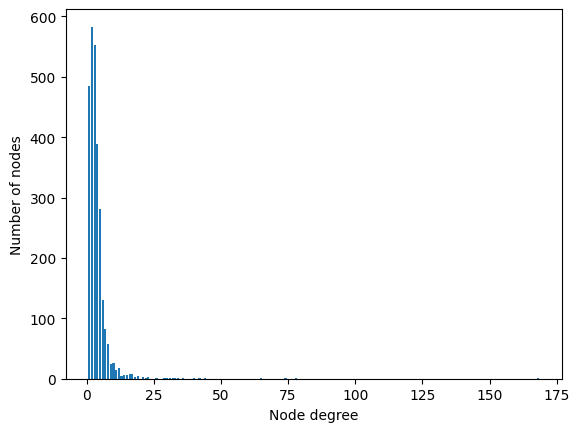

In [8]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 37 artists>

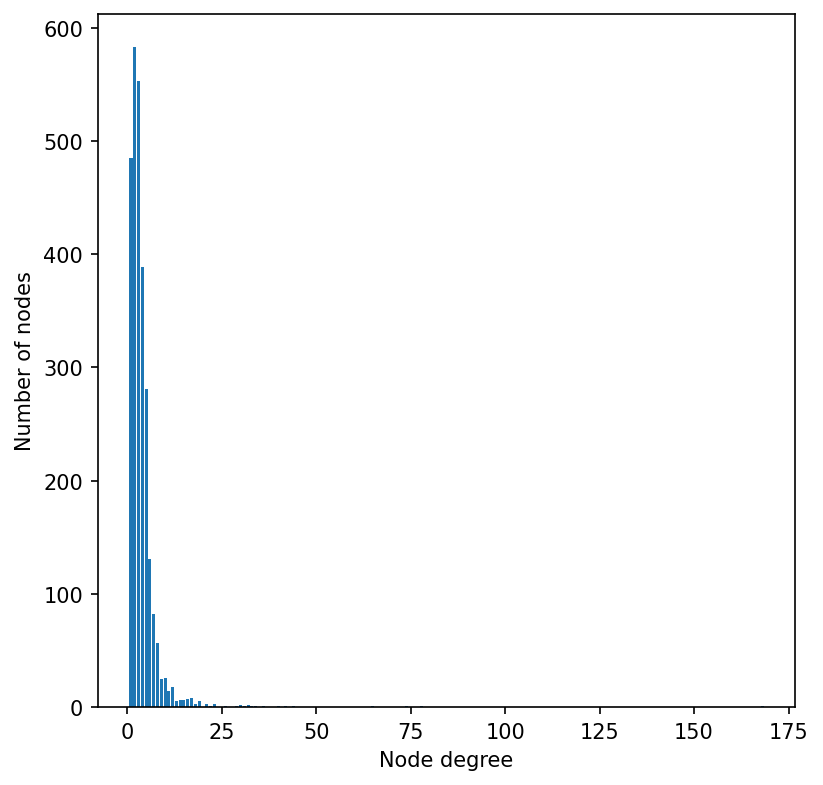

In [11]:
plt.figure(figsize=[6,6], dpi=150)
plt.xlabel("Node degree")
plt.ylabel("Number of nodes")
plt.bar(numbers.keys(), numbers.values())

### With Custom Facebook Page to Page Dataset

In [12]:
# Facebook Page to Page Manual Loading:

from typing import Callable, Optional
import kagglehub
import numpy as np
import torch
import pandas as pd
import json
from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.utils import to_undirected
from sklearn.decomposition import PCA


class ManualFacebookPagePage(InMemoryDataset):
    r"""The Facebook Page-Page network dataset introduced in the
    `"Multi-scale Attributed Node Embedding"
    <https://arxiv.org/abs/1909.13021>`_ paper.
    Nodes represent verified pages on Facebook and edges are mutual likes.
    It contains 22,470 nodes, 342,004 edges, 128 node features and 4 classes.

    Args:
        root (str): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    """

    url = 'https://www.kaggle.com/api/v1/datasets/download/ishandutta/facebook-large-pagepage-network-data-set'

    dataset_path = ""

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> str:
        return [f'{self.dataset_path}/facebook_large/musae_facebook_edges.csv', f'{self.dataset_path}/facebook_large/musae_facebook_features.json', f'{self.dataset_path}/facebook_large/musae_facebook_target.csv']

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        path = kagglehub.dataset_download("ishandutta/facebook-large-pagepage-network-data-set")
        self.dataset_path=path
        print(f"Path to downloaded dataset: {path}")

    def process(self) -> None:
        fb_p2p_edges = pd.read_csv(self.raw_paths[0])
        edge_values = np.array(fb_p2p_edges[['id_1', 'id_2']].values.tolist())
        edge_index = torch.from_numpy(edge_values).to(torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = to_undirected(edge_index)

        with open(self.raw_paths[1], "r") as f:
            fb_p2p_features = json.load(f)
        fb_p2p_features_df = pd.DataFrame({int(key): value for key, value in fb_p2p_features.items()}.items(), columns=['id', 'features'])
        fb_p2p_features_df = fb_p2p_features_df.sort_values(by="id", ascending=True, ignore_index=True)

        fb_p2p_target = pd.read_csv(self.raw_paths[2])

        merged_data = fb_p2p_target.merge(fb_p2p_features_df, on="id")

        merged_data['features'] = merged_data['features'].apply(lambda row: np.array(row))
        
        num_nodes = len(merged_data)

        all_features = [feat for feature_list in merged_data['features'] for feat in feature_list]
        num_features = max(all_features) + 1

        print(num_features)

        indices = [[i, feat] for i, feature_list in enumerate(merged_data['features']) for feat in feature_list]
        values = [1.0] * len(indices)
        x_sparse = torch.sparse_coo_tensor(torch.tensor(indices).t(), values, (num_nodes, num_features))
        
        # Convert to a dense tensor for PCA
        x_dense_numpy = x_sparse.to_dense().numpy()

        print(f"Original feature shape: {x_dense_numpy.shape}")

        # Initialize PCA to reduce the features to 128 dimensions
        pca = PCA(n_components=128)

        # Fit PCA on the data and transform it
        x_pca = pca.fit_transform(x_dense_numpy)

        print(f"New feature shape after PCA: {x_pca.shape}")

        # Convert the resulting NumPy array back to a PyTorch tensor
        x = torch.from_numpy(x_pca).to(torch.float)

        num_targets = 4

        print(num_targets)

        target_map = {"tvshow": 0, "government": 1, "company": 2, "politician": 3}

        y_values = merged_data['page_type'].map(target_map).values
        y = torch.from_numpy(y_values).to(torch.long)

        data = Data(x=x, y=y, edge_index=edge_index)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

In [14]:
dataset = ManualFacebookPagePage(root=".")
data = dataset[0]

Path to downloaded dataset: /home/didiersalest/.cache/kagglehub/datasets/ishandutta/facebook-large-pagepage-network-data-set/versions/1


In [19]:
degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)
numbers

Counter({1.0: 2658,
         34.0: 100,
         12.0: 490,
         10.0: 621,
         51.0: 53,
         22.0: 228,
         16.0: 333,
         3.0: 1850,
         2.0: 2322,
         4.0: 1509,
         6.0: 1114,
         17.0: 349,
         55.0: 36,
         38.0: 85,
         13.0: 453,
         28.0: 146,
         5.0: 1360,
         30.0: 127,
         15.0: 379,
         43.0: 78,
         18.0: 316,
         23.0: 214,
         59.0: 38,
         9.0: 729,
         31.0: 133,
         20.0: 263,
         11.0: 552,
         94.0: 12,
         8.0: 813,
         19.0: 264,
         25.0: 198,
         7.0: 965,
         29.0: 149,
         47.0: 51,
         49.0: 44,
         48.0: 53,
         32.0: 112,
         45.0: 59,
         58.0: 27,
         46.0: 49,
         14.0: 390,
         27.0: 149,
         71.0: 20,
         26.0: 192,
         21.0: 232,
         60.0: 38,
         56.0: 36,
         33.0: 131,
         142.0: 4,
         35.0: 108,
         134.0: 3,


<BarContainer object of 234 artists>

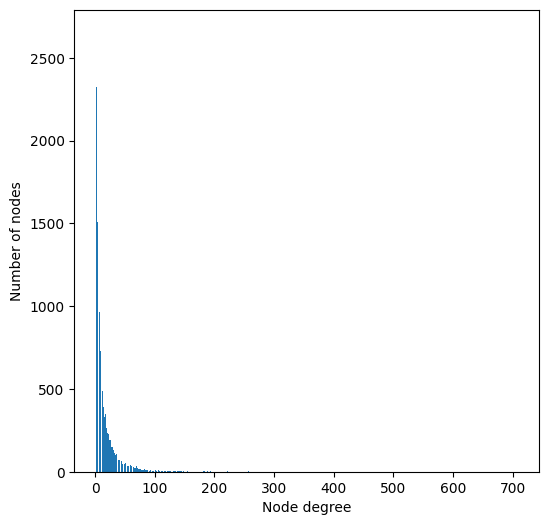

In [17]:
plt.figure(figsize=[6,6])
plt.xlabel("Node degree")
plt.ylabel("Number of nodes")
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 234 artists>

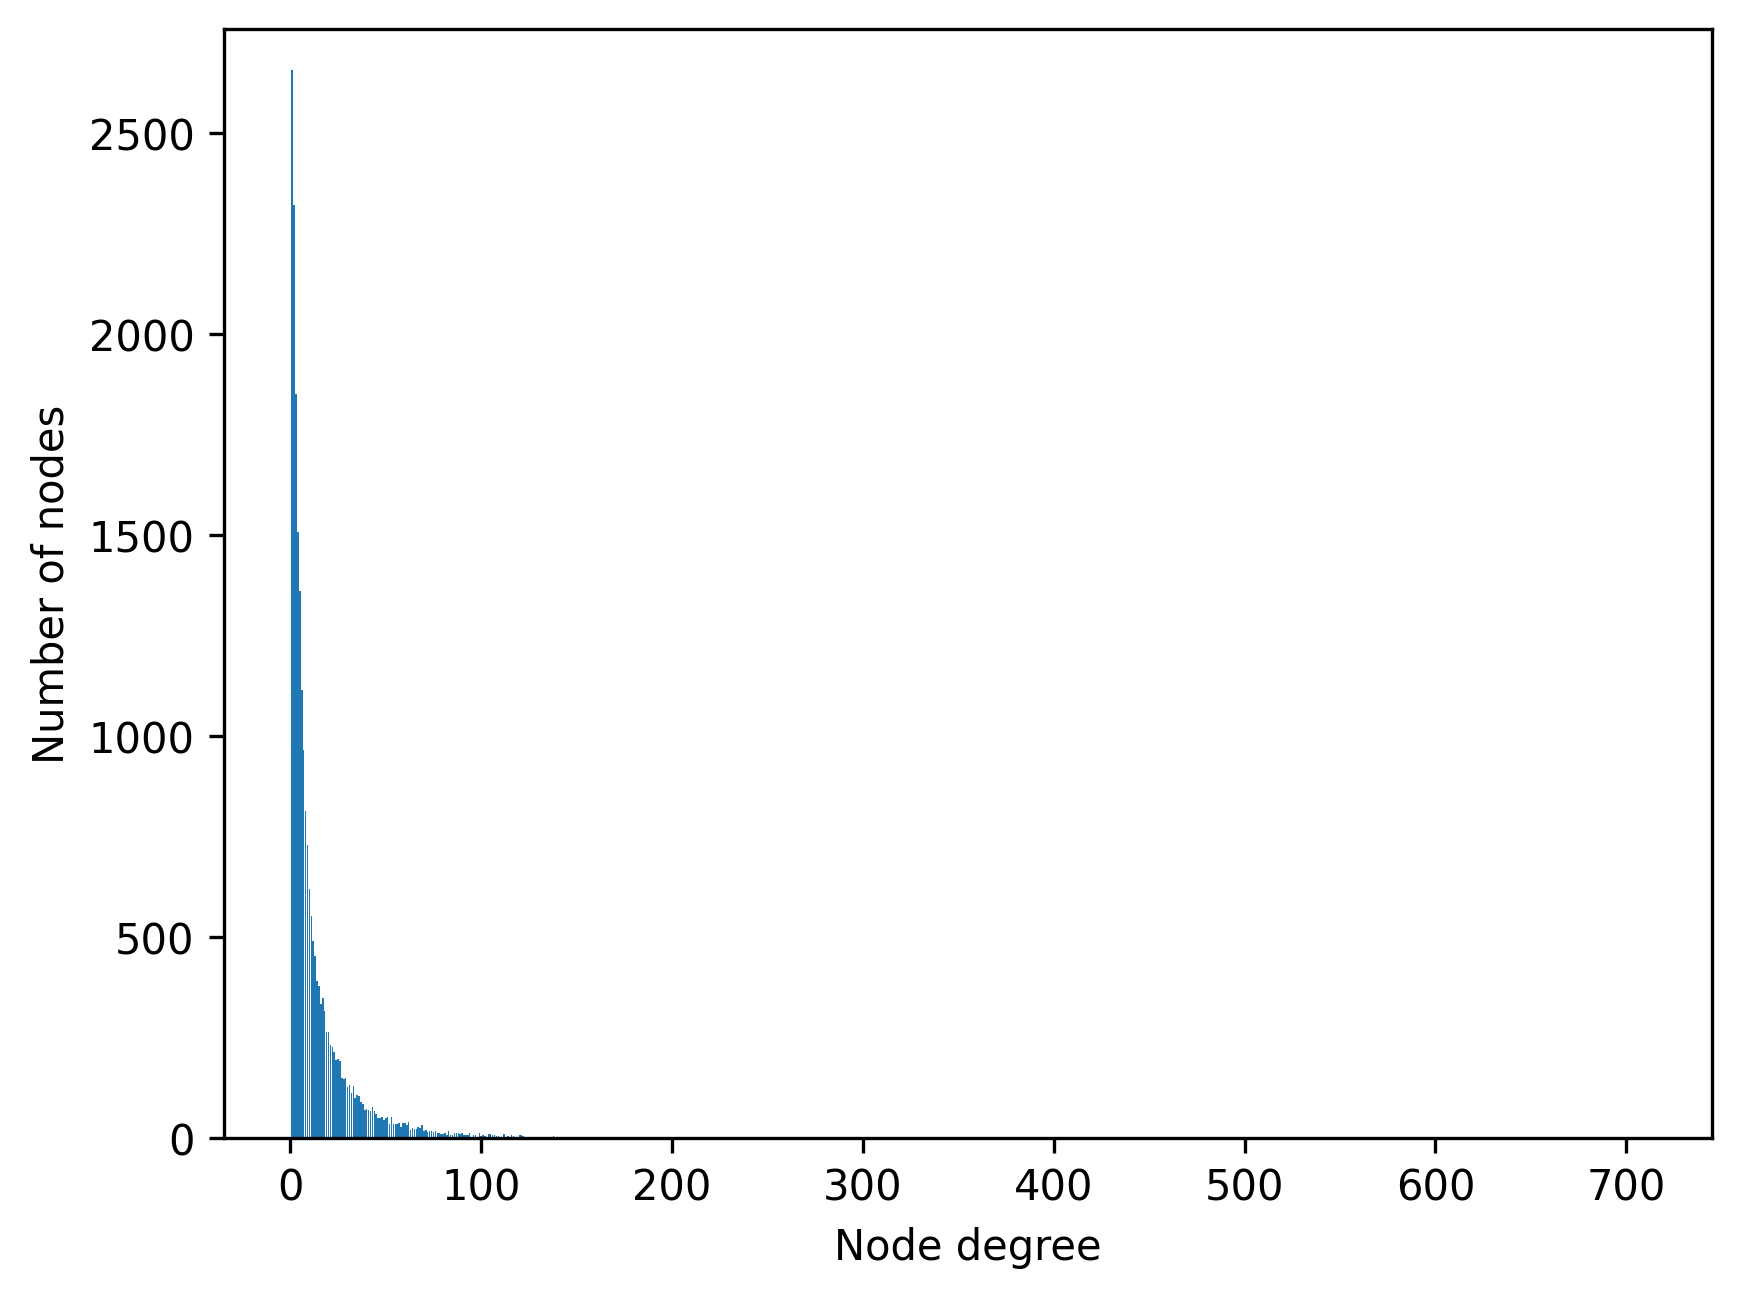

In [24]:
fig, ax = plt.subplots()
fig.dpi=300
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.set_ylim(top=max(numbers.values())+100)
plt.bar(numbers.keys(), numbers.values())

### Implementing GCN:

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [26]:
def accuracy(pred_y, y):
    return ((pred_y==y).sum()/len(y)).item()

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay=5e-4)

        self.train()

        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if (epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

                print(f"Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%")
    
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### With Custom Facebook Page-to-Page Dataset:

In [42]:
dataset = ManualFacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Path to downloaded dataset: /home/didiersalest/.cache/kagglehub/datasets/ishandutta/facebook-large-pagepage-network-data-set/versions/1


In [43]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.414 | Train Acc: 22.60% | Val Loss: 1.42 | Val Acc: 21.91%
Epoch  20 | Train Loss: 0.921 | Train Acc: 67.88% | Val Loss: 0.92 | Val Acc: 68.08%
Epoch  40 | Train Loss: 0.569 | Train Acc: 82.54% | Val Loss: 0.57 | Val Acc: 82.14%
Epoch  60 | Train Loss: 0.390 | Train Acc: 88.29% | Val Loss: 0.39 | Val Acc: 88.84%
Epoch  80 | Train Loss: 0.324 | Train Acc: 90.12% | Val Loss: 0.32 | Val Acc: 90.30%
Epoch 100 | Train Loss: 0.298 | Train Acc: 91.01% | Val Loss: 0.29 | Val Acc: 90.90%


In [44]:
acc = gcn.test(data)
print(f"GCN Test Accuracy: {acc*100:.2f}%")

GCN Test Accuracy: 90.36%


### With Cora dataset:

In [45]:
import torch_geometric.transforms as T
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [46]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.950 | Train Acc: 12.86% | Val Loss: 1.95 | Val Acc: 12.60%
Epoch  20 | Train Loss: 0.123 | Train Acc: 100.00% | Val Loss: 0.80 | Val Acc: 77.20%
Epoch  40 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 78.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.40%


In [47]:
acc = gcn.test(data)
print(f"GCN Test Accuracy: {acc*100:.2f}%")

GCN Test Accuracy: 80.60%


## Predicting web traffic with node regression

In [33]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T
transform = T.RandomNodeSplit(num_val=200, num_test=500)
dataset = WikipediaNetwork(root=".", name="chameleon")

data = transform(dataset[0])
data

Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277], val_mask=[2277], test_mask=[2277])

In [34]:
print(f"Dataset: {dataset}")
print("-------------------")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}") # need to be updated with continous values
print(f"Graph:")
print("-------")
print(f"Edges are directed: {data.is_directed()}")
print(f"Graph has isolated nodes: {data.has_isolated_nodes()}")
print(f"Graph has loops: {data.has_self_loops()}")

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of features: 2325
Number of classes: 5
Graph:
-------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [35]:
import pandas as pd  
import torch
import numpy as np

df = pd.read_csv("wikipedia/chameleon/musae_chameleon_target.csv")
values = np.log10(df["target"])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

/tmp/ipykernel_150553/3558600065.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["target"], fit=norm)


<AxesSubplot: xlabel='target', ylabel='Density'>

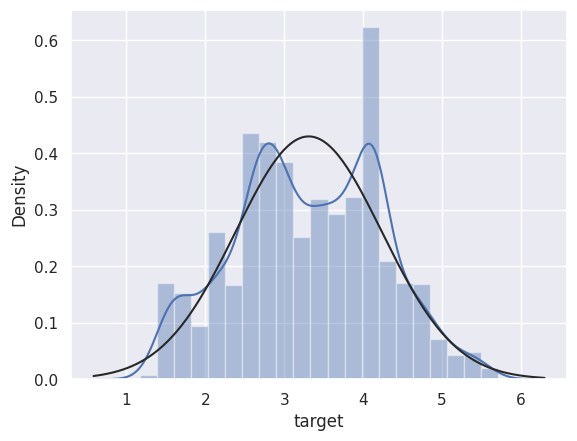

In [36]:
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()
df["target"]= values
sns.distplot(df["target"], fit=norm)

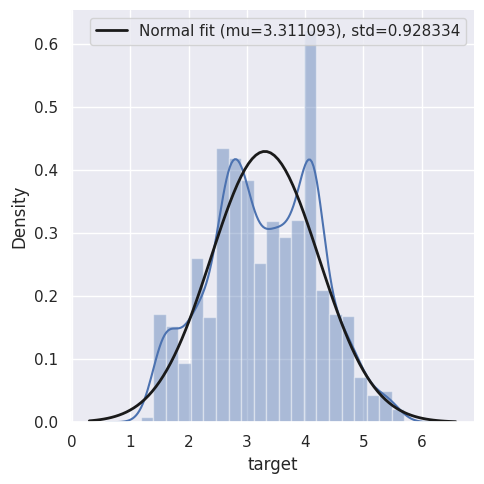

In [37]:
fig = sns.displot(df, x="target", stat="density", kde=True, kde_kws=dict(cut=3), alpha=.4, edgecolor=(1,1,1,.4))
ax2 = fig.ax
mu2, std2 = norm.fit(df["target"])
xmin2, xmax2 = ax2.get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax2.plot(x2, p2, "k", linewidth=2, label=f"Normal fit (mu={mu2:2f}), std={std2:2f}")
ax2.legend()


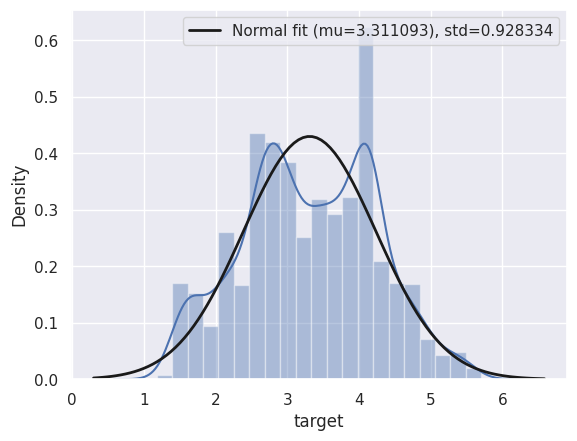

In [38]:
axes = sns.histplot(df, x="target", stat="density", kde=True, kde_kws=dict(cut=3), alpha=.4, edgecolor=(1,1,1,.4))
ax2 = axes
mu2, std2 = norm.fit(df["target"])
xmin2, xmax2 = ax2.get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax2.plot(x2, p2, "k", linewidth=2, label=f"Normal fit (mu={mu2:2f}), std={std2:2f}")
ax2.legend()


In [39]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)
    
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h
    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask].float())
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

In [40]:
gcn = GCN(dataset.num_features, 128, 1)
print(gcn)
gcn.fit(data, epochs = 200)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 12.41787 | Val Loss: 13.20318
Epoch  20 | Train Loss: 10.91236 | Val Loss: 11.68280
Epoch  40 | Train Loss: 4.34330 | Val Loss: 5.18078
Epoch  60 | Train Loss: 0.78768 | Val Loss: 1.05211
Epoch  80 | Train Loss: 0.57268 | Val Loss: 0.83298
Epoch 100 | Train Loss: 0.45066 | Val Loss: 0.85200
Epoch 120 | Train Loss: 0.40387 | Val Loss: 0.86129
Epoch 140 | Train Loss: 0.37686 | Val Loss: 0.82221
Epoch 160 | Train Loss: 0.33918 | Val Loss: 0.74611
Epoch 180 | Train Loss: 0.33050 | Val Loss: 0.74026
Epoch 200 | Train Loss: 0.29641 | Val Loss: 0.67008


In [41]:
loss = gcn.test(data)
print(f"GCN test loss: {loss:.5f}")

GCN test loss: 0.65002


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

In [45]:
print("="*43)
print(f"MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}")
print("="*43)

MSE = 0.6500 | RMSE = 0.8062 | MAE = 0.6082


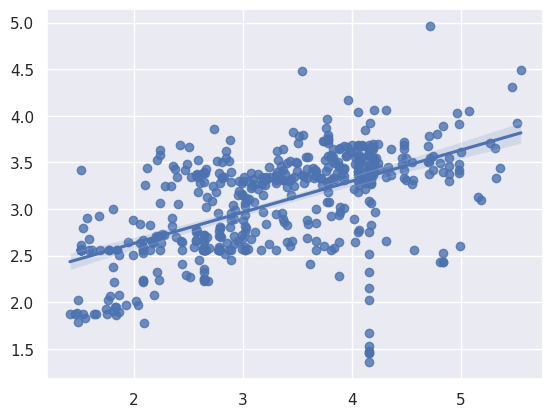

In [46]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)

# Chapter 7

## Graph Attention Networks - Introducing the graph attention layer

## GAT with numpy

In [1]:
import numpy as np
np.random.seed(0)

A = np.array([[1,1,1,1],
              [1,1,0,0],
              [1,0,1,1],
              [1,0,1,1]])

In [2]:
X = np.random.uniform(-1,1,(4,4))

In [4]:
nb = 4 # Number of nodes in the graph

W = np.random.uniform(-1,1, (2,4)) # Regular weight matrix

W_att = np.random.uniform(-1,1,(1,4))

# Concatenating hidden vectors
connections = np.where(A>0) # Obtaining pais of source and destination nodes


np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1)

array([[-0.11673572, -0.12634051, -0.11673572, -0.12634051],
       [-0.11673572, -0.12634051,  0.43205504,  0.35780762],
       [-0.11673572, -0.12634051, -0.16273574, -0.66116004],
       [-0.11673572, -0.12634051, -0.18823534,  0.7359804 ],
       [ 0.43205504,  0.35780762, -0.11673572, -0.12634051],
       [ 0.43205504,  0.35780762,  0.43205504,  0.35780762],
       [-0.16273574, -0.66116004, -0.11673572, -0.12634051],
       [-0.16273574, -0.66116004, -0.16273574, -0.66116004],
       [-0.16273574, -0.66116004, -0.18823534,  0.7359804 ],
       [-0.18823534,  0.7359804 , -0.11673572, -0.12634051],
       [-0.18823534,  0.7359804 , -0.16273574, -0.66116004],
       [-0.18823534,  0.7359804 , -0.18823534,  0.7359804 ]])

In [5]:
# Linear transformation with attention matrix
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1).T

In [7]:
# Applying Leaky ReLU

def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[-0.04105264,  0.45784242, -0.08811403,  0.04485606,  0.03099776,
         0.69410336, -0.06813063, -0.11519202, -0.01810678, -0.00392471,
        -0.05098609,  0.23049572]])

In [10]:
# The variable connections have the coordinates in rows and columns for the nodes that have a connection
# So to make the leaky relu output in the correct matrix format as the adjacency matrix would be like this:

E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[-0.04105264,  0.45784242, -0.08811403,  0.04485606],
       [ 0.03099776,  0.69410336,  0.        ,  0.        ],
       [-0.06813063,  0.        , -0.11519202, -0.01810678],
       [-0.00392471,  0.        , -0.05098609,  0.23049572]])

In [11]:
# normalizing attention scores

def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e/sum

W_alpha = softmax2D(E,1)
W_alpha

array([[0.2131907 , 0.35110387, 0.20339007, 0.23231536],
       [0.20492786, 0.39772613, 0.198673  , 0.198673  ],
       [0.24534879, 0.26264714, 0.23406982, 0.25793424],
       [0.23684688, 0.23777826, 0.22595875, 0.29941611]])

In [12]:
# To get the 2 dimensional embedding vectors for each node we do the following 

H=A.T @ W_alpha @ X @ W.T
H

array([[0.10831488, 0.49066432],
       [0.12816914, 0.26648272],
       [0.03012618, 0.35938079],
       [0.03012618, 0.35938079]])

For multi-head attention we repeat these steps with different W and W_att before aggregating results.

## GAT with pytorch geometric

In [17]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout

def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [23]:
# It is important to declare the number of heads used for multi-head attention
# From authors experiments: 8 heads improved performance for the first layer but made no difference in the second one

class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads = 8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    # Adding dropout layers to avoid overfitting
    # Using the exponential version of Leaky ReLU which is ELU, as the paper showed

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.5f} | Val Acc: {val_acc*100:>.2f}%")
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### Results with the imported Cora dataset

In [26]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.95202 | Train Acc: 11.43% | Val Loss: 1.94785 | Val Acc: 17.20%
Epoch  20 | Train Loss: 0.19491 | Train Acc: 97.14% | Val Loss: 0.89400 | Val Acc: 72.00%
Epoch  40 | Train Loss: 0.17978 | Train Acc: 97.86% | Val Loss: 0.87112 | Val Acc: 72.00%
Epoch  60 | Train Loss: 0.15832 | Train Acc: 100.00% | Val Loss: 0.77980 | Val Acc: 74.00%
Epoch  80 | Train Loss: 0.15011 | Train Acc: 98.57% | Val Loss: 0.88286 | Val Acc: 72.80%
Epoch 100 | Train Loss: 0.14947 | Train Acc: 98.57% | Val Loss: 0.94872 | Val Acc: 72.40%


In [27]:
acc = gat.test(data)

print(f"GAT test accuracy: {acc*100:.2f}%")

GAT test accuracy: 81.30%


### Results with CiteSeet dataset

In [28]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]
data

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [35]:
dataset.num_classes

6

<BarContainer object of 32 artists>

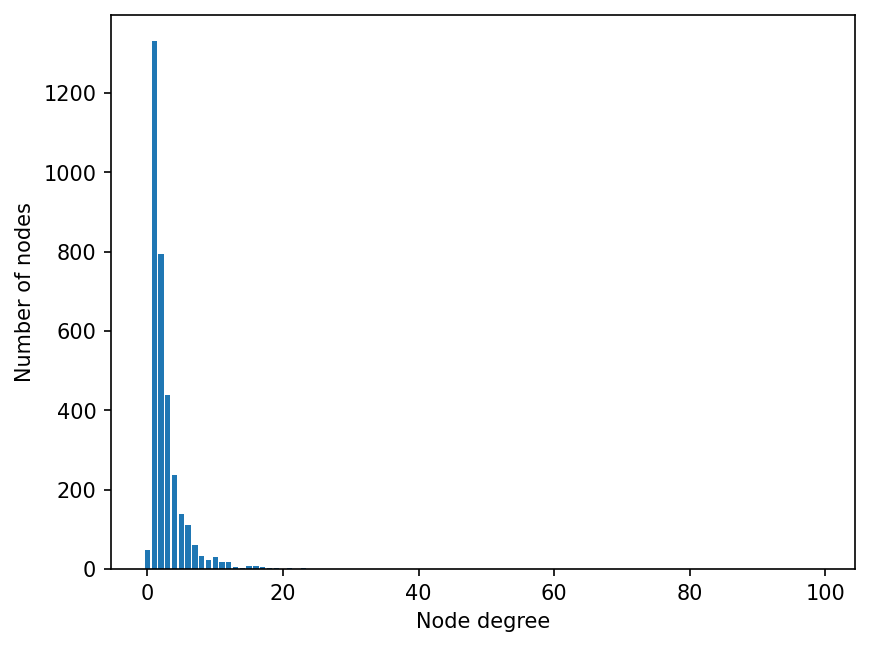

In [30]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)

fig, ax = plt.subplots(dpi=150)
ax.set_xlabel("Node degree")
ax.set_ylabel("Number of nodes")
plt.bar(numbers.keys(), numbers.values())

In [36]:
gat = GAT(dataset.num_features, 16, dataset.num_classes)
gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.81052 | Train Acc: 18.33% | Val Loss: 1.84153 | Val Acc: 13.40%
Epoch  20 | Train Loss: 0.17383 | Train Acc: 96.67% | Val Loss: 1.10630 | Val Acc: 63.80%
Epoch  40 | Train Loss: 0.12400 | Train Acc: 97.50% | Val Loss: 1.22199 | Val Acc: 60.60%
Epoch  60 | Train Loss: 0.14037 | Train Acc: 98.33% | Val Loss: 1.15705 | Val Acc: 61.80%
Epoch  80 | Train Loss: 0.12137 | Train Acc: 97.50% | Val Loss: 1.18519 | Val Acc: 61.80%
Epoch 100 | Train Loss: 0.11651 | Train Acc: 98.33% | Val Loss: 1.16409 | Val Acc: 60.60%


In [37]:
acc = gat.test(data)

print(f"GAT test accuracy: {acc*100:.2f}%")

GAT test accuracy: 67.10%


In [38]:
out = gat(data.x, data.edge_index)
degrees = degree(data.edge_index[0]).numpy()

accuracies = []
sizes = []

In [ ]:
# obtaining avg accuracy with masks for nodes with degree from 0 to 5
for i in range(0,6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

In [ ]:
# obtaining avg accuracy with mask for nodes with degree higher than 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

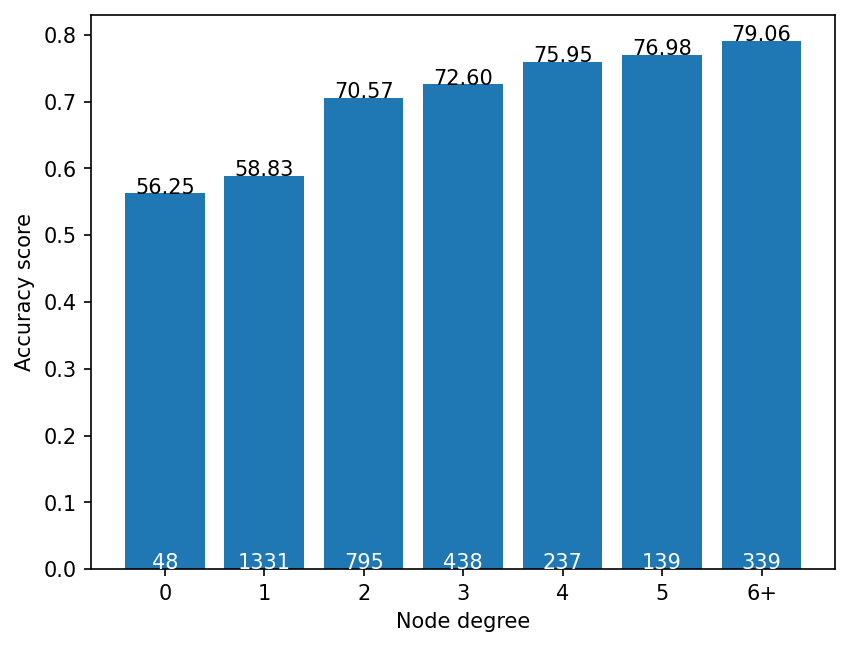

In [ ]:
# From the figure we can see that nodes with few neighbors are higher to classify
# The trend is of an increasing accuracy if a node has more neighbors
fig, ax = plt.subplots(dpi=150)
ax.set_xlabel("Node degree")
ax.set_ylabel("Accuracy score")
plt.bar(["0","1","2","3","4","5","6+"], accuracies)
for i in range(0,7):
    plt.text(i, accuracies[i], f"{accuracies[i]*100:.2f}", ha="center", color="black")
    plt.text(i, accuracies[i]//2, sizes[i], ha="center", color="white")


# Chapter 8

## GraphSAGE

### With PubMed Dataset:

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root=".", name="Pubmed")
data = dataset[0]

In [3]:
print(f"Dataset: {dataset}")
print("-------------------")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}") # need to be updated with continous values
print(f"Graph:")
print("-------")
print(f"Training nodes: {sum(data.train_mask).item()}")
print(f"Validation nodes: {sum(data.val_mask).item()}")
print(f"Test nodes: {sum(data.test_mask).item()}")
print(f"Edges are directed: {data.is_directed()}")
print(f"Graph has isolated nodes: {data.has_isolated_nodes()}")
print(f"Graph has loops: {data.has_self_loops()}")

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3
Graph:
-------
Training nodes: 60
Validation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [4]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    data,
    num_neighbors=[10,10],
    batch_size=16,
    input_nodes=data.train_mask,
)

In [5]:
for i, subgraph in enumerate(train_loader):
    print(f"Subgraph {i}: {subgraph}")

Subgraph 0: Data(x=[506, 500], edge_index=[2, 612], y=[506], train_mask=[506], val_mask=[506], test_mask=[506], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[295, 500], edge_index=[2, 380], y=[295], train_mask=[295], val_mask=[295], test_mask=[295], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[379, 500], edge_index=[2, 452], y=[379], train_mask=[379], val_mask=[379], test_mask=[379], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[243, 500], edge_index=[2, 293], y=[243], train_mask=[243], val_mask=[243], test_mask=[243], input_id=[12], batch_size=12)


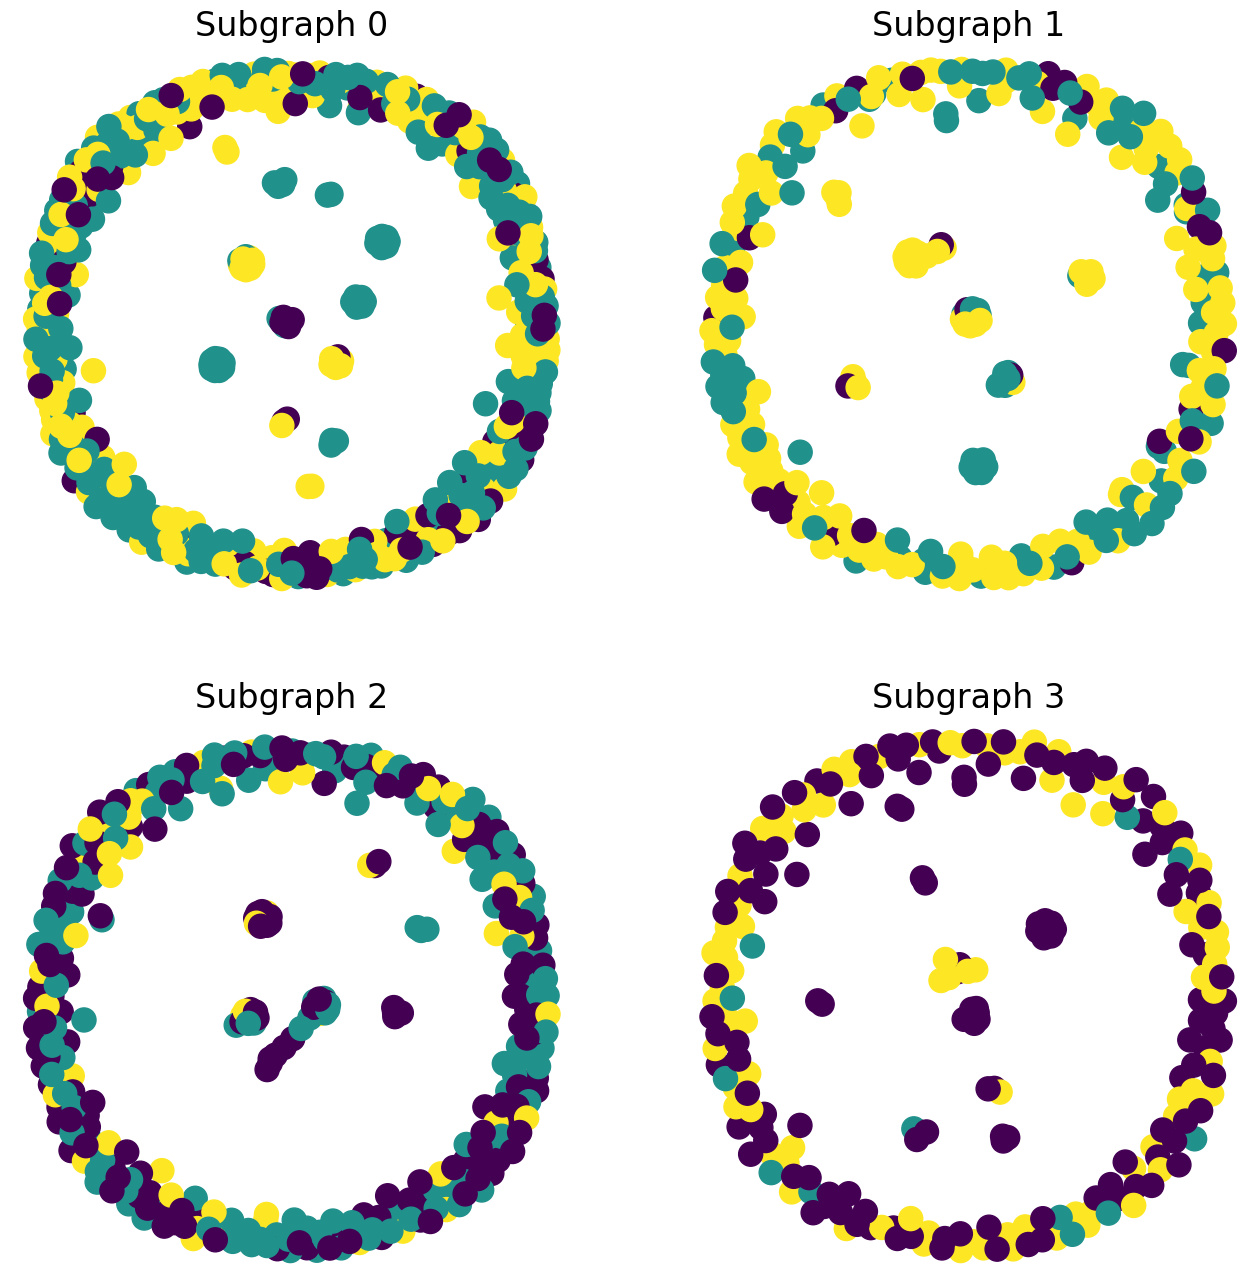

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig = plt.figure(figsize=(16,16))

for idx, (subdata, pos) in enumerate(zip(train_loader, [221,222,223,224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f"Subgraph {idx}", fontsize=24)
    plt.axis("off")
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=False,
                     node_color=subdata.y)
plt.show()

In [8]:
def accuracy(pred_y, y):
    return ((pred_y==y).sum() / len(y)).item()

In [10]:
import torch.nn.functional as F
import torch
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in,dim_h)
        self.sage2 = SAGEConv(dim_h,dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h,dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss, val_loss, acc, val_acc = 0,0,0,0
            for batch in train_loader:
                optimizer.zero_grad()
                out=self(batch.x,batch.edge_index)
                loss=criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss+=loss
                acc+=accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                val_loss+=criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

                if epoch % 20 == 0:
                    print(f"Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.3f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%")
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])

        return acc


In [11]:
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)
graphsage.fit(data, 200)

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.271 | Train Acc:  14.71% | Val Loss: 0.270 | Val Acc: 13.46%
Epoch   0 | Train Loss: 0.256 | Train Acc:  28.77% | Val Loss: 0.529 | Val Acc: 33.46%
Epoch   0 | Train Loss: 0.283 | Train Acc:  31.71% | Val Loss: 0.804 | Val Acc: 36.24%
Epoch   0 | Train Loss: 0.345 | Train Acc:  31.71% | Val Loss: 1.117 | Val Acc: 36.24%
Epoch  20 | Train Loss: 0.003 | Train Acc:  25.00% | Val Loss: 0.163 | Val Acc: 20.83%
Epoch  20 | Train Loss: 0.001 | Train Acc:  50.00% | Val Loss: 0.359 | Val Acc: 37.50%
Epoch  20 | Train Loss: 0.006 | Train Acc:  75.00% | Val Loss: 0.503 | Val Acc: 54.17%
Epoch  20 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.648 | Val Acc: 72.02%
Epoch  40 | Train Loss: 0.001 | Train Acc:  25.00% | Val Loss: 0.209 | Val Acc: 15.38%
Epoch  40 | Train Loss: 0.001 | Train Acc:  50.00% | Val Loss: 0.392 | Val Acc: 35.38%
Epoch  40 | Train Loss: 0.001 | Train A

In [12]:
acc = graphsage.test(data)

print(f"GraphSAGE test accuracy: {acc*100:.2f}%")

GraphSAGE test accuracy: 76.30%


### With Protein Protein Interactions Dataset - Inductive approach:

Inductive: Train with only training data and test on unseen data.
Transductive: Train with both training and test data, learn only from the training data (calculate loss with training data only) and test at the end.

So before we were only using the transductive approach as we were using the whole graph with masked nodes for training, validation and test. Now we are going to use GraphSAGE in an inductive approach, as the neighbor sampling allows for generalization on unseen data.

In [13]:
from torch_geometric.datasets import PPI

train_dataset = PPI(root=".", split="train")
val_dataset = PPI(root=".", split="val")
test_dataset = PPI(root=".", split="test")

Extracting ./ppi.zip
Processing...
Done!


In [15]:
from torch_geometric.data import Batch
from torch_geometric.loader import NeighborLoader

train_data = Batch.from_data_list(train_dataset)
loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20,10], num_workers=2, persistent_workers=True)

In [16]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
from torch_geometric.nn import GraphSAGE

model = GraphSAGE(
    in_channels=train_dataset.num_features, hidden_channels=512, num_layers=2, out_channels=train_dataset.num_classes
).to(device)

In [21]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit():
    model.train()

    total_loss = 0

    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        loss = criterion(out, data.y)

        total_loss += loss.item()*data.num_graphs

        loss.backward()
        optimizer.step()
    
    return total_loss / len(train_loader.dataset)

In [22]:
from sklearn.metrics import f1_score

@torch.no_grad()
def test(loader):
    model.eval()
    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))

    preds = (out>0).float().cpu()
    y,pred = data.y.numpy(), preds.numpy()

    return f1_score(y, pred, average="micro") if pred.sum()>0 else 0

In [23]:
for epoch in range(301):
    loss = fit()
    val_f1 = test(val_loader)
    if epoch % 50 ==0:
        print(f"Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1 Score: {val_f1:.4f}")

Epoch   0 | Train Loss: 0.589 | Val F1 Score: 0.4029
Epoch  50 | Train Loss: 0.200 | Val F1 Score: 0.8314
Epoch 100 | Train Loss: 0.146 | Val F1 Score: 0.8777
Epoch 150 | Train Loss: 0.122 | Val F1 Score: 0.8946
Epoch 200 | Train Loss: 0.110 | Val F1 Score: 0.9000
Epoch 250 | Train Loss: 0.097 | Val F1 Score: 0.9118
Epoch 300 | Train Loss: 0.091 | Val F1 Score: 0.9141


In [24]:
print(f"Test F1 Score: {test(test_loader):4f}")

Test F1 Score: 0.934150


# Chapter 9

## Implementing the GIN (Graph Isomorphism Network):

In [25]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root=".", name="PROTEINS").shuffle()

print(f"Dataset: {dataset}")
print(f"----------------------------")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {dataset[0].x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Extracting ./PROTEINS/PROTEINS.zip
Processing...
Done!


Dataset: PROTEINS(1113)
----------------------------
Number of graphs: 1113
Number of nodes: 21
Number of features: 3
Number of classes: 2


In [26]:
from torch_geometric.loader import DataLoader
# Split in 80/10/10
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = dataset[int(len(dataset)*0.9):]

print(f"Training set = {len(train_dataset)} graphs")
print(f"Validation set = {len(val_dataset)} graphs")
print(f"Test set = {len(test_dataset)} graphs")

Training set = 890 graphs
Validation set = 111 graphs
Test set = 112 graphs


In [27]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [28]:
print("\nTrain Loader:")

for i, batch in enumerate(train_loader):
    print(f" - Batch {i}: {batch}")

print("\nValidation Loader:")

for i, batch in enumerate(val_loader):
    print(f" - Batch {i}: {batch}")

print("\nTest Loader:")

for i, batch in enumerate(test_loader):
    print(f" - Batch {i}: {batch}")


Train Loader:
 - Batch 0: DataBatch(edge_index=[2, 8664], x=[2240, 3], y=[64], batch=[2240], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 8196], x=[2239, 3], y=[64], batch=[2239], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 10844], x=[2962, 3], y=[64], batch=[2962], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 9846], x=[2519, 3], y=[64], batch=[2519], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 8922], x=[2436, 3], y=[64], batch=[2436], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 9832], x=[2601, 3], y=[64], batch=[2601], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 10084], x=[2545, 3], y=[64], batch=[2545], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 9712], x=[2598, 3], y=[64], batch=[2598], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 9910], x=[2775, 3], y=[64], batch=[2775], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 8526], x=[2339, 3], y=[64], batch=[2339], ptr=[65])
 - Batch 10: DataBatch(edge_index=[2, 9230], x=[2493, 3], y=[64], batch=[2493], ptr=[65])
 - 

In [38]:
import torch
torch.manual_seed(0)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool

class GIN(torch.nn.Module):
    def __init__(self, dim_h):
        super(GIN,self).__init__()
        self.conv1 = GINConv(Sequential(Linear(dataset.num_node_features, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(Sequential(Linear(dim_h,dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h,dim_h), ReLU()))
        self.conv3=GINConv(Sequential(Linear(dim_h,dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h,dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)
    
    def forward(self, x, edge_index, batch):
        # Node Embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)
    
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0 
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out=model(data.x, data.edge_index, data.batch)
            loss = criterion(out,data.y)
            total_loss += loss/len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader)
        
        if(epoch % 20  == 0):
            print(f"Epoch {epoch:>3} | Train Loss: {total_loss:.3f} | Train Acc: {acc*100:>6.2f}% | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%")
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()

    model.eval()
    loss = 0
    acc = 0

    for data in loader:

        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [42]:
gin = GIN(dim_h=32)
gin=train(gin, train_loader)

Epoch   0 | Train Loss: 1.273 | Train Acc:  61.83% | Val Loss: 0.560 | Val Acc: 73.04%
Epoch  20 | Train Loss: 0.511 | Train Acc:  75.82% | Val Loss: 0.521 | Val Acc: 76.01%
Epoch  40 | Train Loss: 0.487 | Train Acc:  76.42% | Val Loss: 0.451 | Val Acc: 78.99%
Epoch  60 | Train Loss: 0.473 | Train Acc:  77.32% | Val Loss: 0.456 | Val Acc: 77.99%
Epoch  80 | Train Loss: 0.464 | Train Acc:  78.22% | Val Loss: 0.452 | Val Acc: 80.27%
Epoch 100 | Train Loss: 0.474 | Train Acc:  77.75% | Val Loss: 0.471 | Val Acc: 78.42%


In [43]:
test_loss, test_acc = test(gin, test_loader)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:>6.2f}%")

Test Loss: 0.574 | Test Acc:  71.88%
